In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Optional
from jax.random import PRNGKey

seed = 12
key = PRNGKey(seed)

S = 30
A = 3
S_set = jnp.arange(S)
A_set = jnp.arange(A)
H = 10

# create reward function
rew = jnp.ones((H, S, A))
key, _ = jax.random.split(key)
zero_mask = jax.random.bernoulli(key, p=0.5, shape=rew.shape)
rew = rew * zero_mask
assert rew.shape == (H, S, A)
assert rew.max() > 0


# create reward function for constraints
utility = 1 - rew


# create transition probability kernel
key, _ = jax.random.split(key)
P = jax.random.dirichlet(key=key, alpha=jnp.array([0.1] * S), shape=(H, S*A))
P = P.reshape(H, S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)


# create initial distribution
key, _ = jax.random.split(key)
init_dist = jnp.zeros(S)
x0 = jax.random.randint(key, (), 0, S)
init_dist = init_dist.at[x0].set(1.0)
np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)


class CMDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    H: int  # horizon
    rew: jnp.array  # reward function
    utility: jnp.array  # reward for constraint
    const: float  # constraint threshold
    P: jnp.array  # transition probability kernel
    init_dist: jnp.array  # initial distribution
    optimal_V_rew: Optional[jnp.ndarray] = None
    optimal_V_utility: Optional[jnp.ndarray] = None

    @property
    def S(self) -> int:  # state space size
        return len(self.S_set)

    @property
    def A(self) -> int:  # action space size
        return len(self.A_set)


const = 0  # dummy
mdp = CMDP(S_set, A_set, H, rew, utility, const, P, init_dist)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
import chex

@jax.jit
def compute_greedy_Q(mdp: CMDP):
    """Compute a greedy Q function with respect to the utility function
    """
    def backup(i, greedy_Q):
        h = H - i - 1
        V = greedy_Q[h+1].max(axis=1)
        next_v = mdp.P[h] @ V
        chex.assert_shape(next_v, (S, A))
        greedy_Q = greedy_Q.at[h].set(mdp.utility[h] + next_v)
        return greedy_Q

    greedy_Q = jnp.zeros((H+1, S, A))
    greedy_Q = jax.lax.fori_loop(0, mdp.H, backup, greedy_Q)
    return greedy_Q[:-1]


uni_policy = jnp.ones((H, S, A)) / A
greedy_Q = compute_greedy_Q(mdp)
maximum_utility = (greedy_Q).max(axis=-1)[0] @ mdp.init_dist

# Set the constraint threshold
mdp = mdp._replace(const=maximum_utility * 0.5)

In [3]:
from functools import partial
import jax
import chex


@jax.jit
def EvalPolicy(mdp: CMDP, policy: jnp.ndarray, tau: float):
    """ Compute the expected (regularized) value function
    Args:
        mdp (CMDP)
        policy (np.ndarray): (HxSxA) array
        tau (float): entropy coefficient

    Returns:
        policy_Q_rew (jnp.ndarray): (HxSxA)
        policy_Q_utility (jnp.ndarray): (HxSxA)
    """
    H, S, A = policy.shape

    def backup(i, args):
        policy_Q, g, _tau = args
        h = H - i - 1
        Q = policy_Q[h+1] + _tau * jax.scipy.special.entr(policy[h+1])
        V = (policy[h+1] * Q).sum(axis=1)
        next_v = mdp.P[h] @ V
        chex.assert_shape(next_v, (S, A))
        policy_Q = policy_Q.at[h].set(g[h] + next_v)
        min_thresh = (1 + _tau * jnp.log(A)) * (H - h)
        policy_Q = jnp.minimum(policy_Q, min_thresh)
        return policy_Q, g, _tau

    # evaluate regularized Q for reward
    policy_Q_rew = jnp.zeros((H+1, S, A))
    args = policy_Q_rew, mdp.rew, tau
    policy_Q_rew, *_ = jax.lax.fori_loop(0, mdp.H, backup, args)

    # evaluate non-regularized Q for utility
    policy_Q_utility = jnp.zeros((H+1, S, A))
    args = policy_Q_utility, mdp.utility, 0
    policy_Q_utility, *_ = jax.lax.fori_loop(0, mdp.H, backup, args)
    return policy_Q_rew[:-1], policy_Q_utility[:-1]


# test
uni_policy = jnp.ones((H, S, A)) / A
Q_rew_reg, Q_util_reg = EvalPolicy(mdp, uni_policy, 0.1)
Q_rew, Q_util = EvalPolicy(mdp, uni_policy, 0)
assert jnp.all(Q_rew_reg >= Q_rew)
assert jnp.all(Q_util_reg == Q_util)

In [4]:
# compute the optimal policy under the CMDP by linear programming
from scipy.optimize import linprog
from itertools import product
B = np.zeros((H, S, A, H, S, A))

for s, a in product(range(S), range(A)):
    B[0, s, a, 0, s] = 1

for h, s, a in product(range(1, H), range(S), range(A)):
    B[h, s, a, h, s] = 1
    B[h, s, a, h-1] = -mdp.P[h-1, :, :, s]

B = B.reshape((H*S*A, H*S*A))
mu = np.repeat(mdp.init_dist[:, None], A, axis=1).reshape(-1)
b = np.hstack((mu, np.zeros((H-1)*S*A)))

U = mdp.utility.reshape(1, -1)
u = np.array((mdp.const,))

r = - mdp.rew.reshape(-1)
lin_res = linprog(r, A_eq=B, b_eq=b, bounds=(0, None), A_ub=-U, b_ub=-u)

d_arr = lin_res.x.reshape(H, S, A)
np.testing.assert_allclose(d_arr.sum(axis=(1, 2)), 1.0, atol=1e-4)


In [5]:
optimal_policy = d_arr / d_arr.sum(axis=-1, keepdims=True)
optimal_policy = jnp.where(jnp.isnan(optimal_policy), 1 / mdp.A, optimal_policy)
Q_rew, Q_utility = EvalPolicy(mdp, optimal_policy, 0)
V_rew, V_utility = (Q_rew * optimal_policy).sum(axis=-1), (Q_utility * optimal_policy).sum(axis=-1)

total_utility = V_utility[0] @ mdp.init_dist
assert total_utility >= mdp.const - 1e-5
print("Constraint value of the optimal policy", total_utility)

total_rew = V_rew[0] @ mdp.init_dist
print("Optimality of the optimal policy", total_rew)

mdp = mdp._replace(optimal_V_rew=V_rew, optimal_V_utility=V_utility)

# compute bgap
bgap = H / (maximum_utility - mdp.const)
print("bgap", bgap)

Constraint value of the optimal policy 4.811598
Optimality of the optimal policy 5.188404
bgap 2.0783112


/tmp/ipykernel_84863/3313846272.py:1: RuntimeWarning: invalid value encountered in divide
  optimal_policy = d_arr / d_arr.sum(axis=-1, keepdims=True)


In [6]:
from jax.random import PRNGKey
from functools import partial


@partial(jax.jit, static_argnames=("N",))
def sample_next_state(mdp: CMDP, N: int, key: PRNGKey, D: jnp.array):
    """ Sample N next states
    Args:
        mdp (MDP)
        N (int)
        key (PRNGKey)
        D (np.ndarray): pairs of state-action [(h1, s1, a1), (h1, s2, a2), ...]

    Returns:
        new_key (PRNGKey)
        next_s_set (np.ndarray): (len(D) x N)
        count_HSAS (jnp.ndarray): (H x S x A x S) visitation counts of each (h, s, a, s')
    """
    new_key, key = jax.random.split(key)
    keys = jax.random.split(key, num=len(D))

    @jax.vmap
    def choice(key, hsa):
        return jax.random.choice(key, mdp.S_set, shape=(N,), p=P[hsa[0], hsa[1], hsa[2]])

    next_s = choice(keys, D)

    # count the number of (h, s, a, ns)
    H, S, A, S = mdp.P.shape
    count_HSAS = jnp.zeros((H*S*A, S))
    count_D_next_S = jax.vmap(lambda next_s: jnp.bincount(next_s, minlength=S, length=S))(next_s)
    D_ravel = jnp.ravel_multi_index(D.T, (H, S, A), mode="wrap")
    count_HSAS = count_HSAS.at[D_ravel].add(count_D_next_S)
    count_HSAS = count_HSAS.reshape(H, S, A, S)
    return new_key, next_s, count_HSAS

In [7]:
@jax.jit
def collect_samples(mdp: CMDP, key: PRNGKey, policy: jnp.array, init_s: int):
    """ collect data through interaction to the mdp 
    Args:
        mdp (MDP)
        H (int)
        key (PRNGKey)
        policy (jnp.ndarray)
        init_s (int): initial state

    Returns:
        new_key (PRNGKey)
        count_HSAS (jnp.ndarray): (H x S x A x S) visitation counts of each (h, s, a, s')
    """
    H, S, A, S = mdp.P.shape
    chex.assert_shape(policy, (H, S, A))

    def body_fn(h, args):
        key, s, count_HSAS = args
        key, new_key = jax.random.split(key)
        act = jax.random.choice(new_key, A, p=policy[h, s])

        # sample next state
        key, new_key = jax.random.split(key)
        next_s = jax.random.choice(new_key, mdp.S_set, p=P[h, s, act])

        count_HSAS = count_HSAS.at[h, s, act, next_s].add(1)
        return key, next_s, count_HSAS

    count_HSAS = jnp.zeros((H, S, A, S))
    args = key, init_s, count_HSAS
    key, _, count_HSAS = jax.lax.fori_loop(0, H, body_fn, args)
    return key, count_HSAS

In [8]:
@jax.jit
def sample_and_compute_regret(key, mdp: CMDP, policy):
    # sample data and update visitation counter
    key, init_key = jax.random.split(key)
    init_s = jax.random.choice(init_key, S, p=mdp.init_dist)
    key, count_HSAS = collect_samples(mdp, key, policy, init_s)

    # compute temporal regret
    Q_rew, Q_utility = EvalPolicy(mdp, policy, 0)
    init_dist = mdp.init_dist
    total_rew = ((Q_rew * policy)[0].sum(axis=-1) * init_dist).sum()
    total_utility = ((Q_utility * policy)[0].sum(axis=-1) * init_dist).sum()
    
    err_rew = (mdp.optimal_V_rew[0] * init_dist).sum() - total_rew
    err_vio = mdp.const - total_utility
    return key, count_HSAS, err_rew, err_vio

In [9]:
from functools import partial
import jax
import chex


@jax.jit
def compute_bonus_mdp(mdp: CMDP, visit_HSAS: jnp.ndarray, P_approx: jnp.ndarray, K: int, scaler: float, delta: float):
    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    Var = P_approx * (1 - P_approx)
    LP = jnp.log(6 * S * A * H * K / delta)
    bonus_P = jnp.sqrt(Var * LP / visit_HSA) + 14 / 3 * LP / visit_HSA
    bonus = scaler * H * bonus_P.sum(axis=-1)

    bonus_rew = mdp.rew + bonus
    bonus_utility = mdp.utility + bonus

    bonus_mdp = mdp._replace(rew=bonus_rew, utility=bonus_utility, P=P_approx)
    return bonus_mdp


@jax.jit
def update_policy(Q, policy, lr):
    new_policy = jnp.zeros_like(Q)
    H, S, A = Q.shape
    
    def body_fn(i, new_policy):
        pol = jax.nn.softmax(jnp.log(policy[i]) + lr * Q[i])
        new_policy = new_policy.at[i].set(pol)
        return new_policy

    new_policy = jax.lax.fori_loop(0, H, body_fn, new_policy)
    chex.assert_shape(new_policy, (H, S, A))
    return new_policy


@jax.jit
def update(k, args):
    errors_rew, errors_vio, policy, key, visit_HSAS, lam, K, bonus_scaler, delta, tK, tlam = args
    key, count_HSAS, err_rew, err_vio = sample_and_compute_regret(key, mdp, policy)
    visit_HSAS = visit_HSAS + count_HSAS
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(err_vio)

    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    P_approx = jnp.where(visit_HSAS.sum(axis=-1, keepdims=True) > 0, visit_HSAS / visit_HSA, 1 / S)

    # policy evaluation
    bonus_mdp = compute_bonus_mdp(mdp, visit_HSAS, P_approx, K, bonus_scaler, delta)
    Q_rew, Q_utility = EvalPolicy(bonus_mdp, policy, 0)
    Q = Q_rew + lam * Q_utility

    # update policy
    policy = update_policy(Q, policy, tK)

    # update Lagrange
    total_utility = jnp.sum((Q_utility * policy)[0].sum(axis=-1) * mdp.init_dist)
    lam = jnp.maximum(lam + (mdp.const - total_utility) / tlam, 0)
    return errors_rew, errors_vio, policy, key, visit_HSAS, lam, K, bonus_scaler, delta, tK, tlam 



def OptPrimalDualCMDP(mdp: CMDP, iteration: int, K: float, bonus_scaler: float, delta: float):
    S, A, H = mdp.S, mdp.A, mdp.H
    visit_HSAS = np.zeros((H, S, A, S))
    tlam = jnp.sqrt(H ** 2 * K / bgap ** 2)
    tK = jnp.sqrt(2 * jnp.log(A) / (H ** 2 * (1 + bgap) ** 2 * K))

    key = PRNGKey(seed)

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    lam = 0.0
    args = errors_rew, errors_vio, policy, key, visit_HSAS, lam, K, bonus_scaler, delta, tK, tlam
    errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, update, args)
    return errors_rew, errors_vio


In [10]:
import jax
import chex


@jax.jit
def upac_compute_bonus_mdp(mdp: CMDP, visit_HSAS: jnp.ndarray, P_approx: jnp.ndarray, scaler: float, delta: float):
    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1), 1)
    LP = jnp.log(48 * S ** 2 * A * H / delta)
    phi = 2 * jnp.log(jnp.log(jnp.maximum(2 * visit_HSA, jnp.e))) + 2 * LP
    phi = jnp.sqrt(phi / visit_HSA)
    bonus = jnp.sqrt(P_approx).sum(axis=-1) * phi + 5 * phi ** 2
    bonus = scaler * bonus

    bonus_rew = mdp.rew + bonus
    bonus_utility = mdp.utility + bonus

    bonus_mdp = mdp._replace(rew=bonus_rew, utility=bonus_utility, P=P_approx)
    return bonus_mdp


@jax.jit
def upac_update_policy(Q, policy, lr, ent_coef):
    new_policy = jnp.zeros_like(Q)
    H, S, A = Q.shape
    
    def body_fn(i, new_policy):
        pol = jax.nn.softmax((1 - lr * ent_coef) * jnp.log(policy[i]) + lr * Q[i])
        new_policy = new_policy.at[i].set(pol)
        return new_policy

    new_policy = jax.lax.fori_loop(0, H, body_fn, new_policy)
    chex.assert_shape(new_policy, (H, S, A))
    return new_policy


@jax.jit
def upac_update(k, args):
    alpha_eta = 0.53
    alpha_tau = 0.4
    eta_k = (k + 3) ** (-alpha_eta)
    tau_k = (k + 3) ** (-alpha_tau)

    errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta = args

    key, count_HSAS, err_rew, err_vio = sample_and_compute_regret(key, mdp, policy)
    visit_HSAS = visit_HSAS + count_HSAS
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(err_vio)

    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    P_approx = jnp.where(visit_HSAS.sum(axis=-1, keepdims=True) > 0, visit_HSAS / visit_HSA, 1 / S)

    # evaluate policy
    bonus_mdp = upac_compute_bonus_mdp(mdp, visit_HSAS, P_approx, bonus_scaler, delta)
    Q_rew, Q_utility = EvalPolicy(bonus_mdp, policy, tau_k)
    Q = Q_rew + lam * Q_utility

    # update policy
    policy = upac_update_policy(Q, policy, eta_k, tau_k)

    # update Lagrange
    total_utility = jnp.sum((Q_utility * policy)[0].sum(axis=-1) * mdp.init_dist)
    lam = jnp.maximum(lam + eta_k * (mdp.const - total_utility - tau_k * lam), 0)

    return errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta


def UOptRPGPD(mdp: CMDP, iteration: int, bonus_scaler: float, delta: float):
    S, A, H = mdp.S, mdp.A, mdp.H
    visit_HSAS = np.zeros((H, S, A, S))

    key = PRNGKey(seed)

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    lam = 0.0
    args = errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta
    errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, upac_update, args)
    return errors_rew, errors_vio


In [11]:
import jax
import chex


@jax.jit
def no_upac_bonus_update(k, args):
    alpha_eta = 0.53
    alpha_tau = 0.4
    eta_k = (k + 3) ** (-alpha_eta)
    tau_k = (k + 3) ** (-alpha_tau)

    errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta, K = args

    key, count_HSAS, err_rew, err_vio = sample_and_compute_regret(key, mdp, policy)
    visit_HSAS = visit_HSAS + count_HSAS
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(err_vio)

    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    P_approx = jnp.where(visit_HSAS.sum(axis=-1, keepdims=True) > 0, visit_HSAS / visit_HSA, 1 / S)

    # evaluate policy
    bonus_mdp = compute_bonus_mdp(mdp, visit_HSAS, P_approx, K, bonus_scaler, delta)
    Q_rew, Q_utility = EvalPolicy(bonus_mdp, policy, tau_k)
    Q = Q_rew + lam * Q_utility

    # update policy
    policy = upac_update_policy(Q, policy, eta_k, tau_k)

    # update Lagrange
    total_utility = jnp.sum((Q_utility * policy)[0].sum(axis=-1) * mdp.init_dist)
    lam = jnp.maximum(lam + eta_k * (mdp.const - total_utility - tau_k * lam), 0)

    return errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta, K


def UOptRPGPD_NoUPAC(mdp: CMDP, iteration: int, bonus_scaler: float, delta: float, K: int):
    S, A, H = mdp.S, mdp.A, mdp.H
    visit_HSAS = np.zeros((H, S, A, S))

    key = PRNGKey(seed)

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    lam = 0.0
    args = errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta, K
    errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, no_upac_bonus_update, args)
    return errors_rew, errors_vio


In [12]:
import jax
import chex


@jax.jit
def no_ent_update(k, args):
    alpha_eta = 0.53
    eta_k = (k + 3) ** (-alpha_eta)

    errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta = args

    key, count_HSAS, err_rew, err_vio = sample_and_compute_regret(key, mdp, policy)
    visit_HSAS = visit_HSAS + count_HSAS
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(err_vio)

    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    P_approx = jnp.where(visit_HSAS.sum(axis=-1, keepdims=True) > 0, visit_HSAS / visit_HSA, 1 / S)

    # evaluate policy
    bonus_mdp = upac_compute_bonus_mdp(mdp, visit_HSAS, P_approx, bonus_scaler, delta)
    Q_rew, Q_utility = EvalPolicy(bonus_mdp, policy, 0)
    Q = Q_rew + lam * Q_utility

    # update policy
    policy = upac_update_policy(Q, policy, eta_k, 0)

    # update Lagrange
    total_utility = jnp.sum((Q_utility * policy)[0].sum(axis=-1) * mdp.init_dist)
    lam = jnp.maximum(lam + eta_k * (mdp.const - total_utility - 0 * lam), 0)

    return errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta


def UOptRPGPD_NoEntropy(mdp: CMDP, iteration: int, bonus_scaler: float, delta: float):
    S, A, H = mdp.S, mdp.A, mdp.H
    visit_HSAS = np.zeros((H, S, A, S))

    key = PRNGKey(seed)

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    lam = 0.0
    args = errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta
    errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, no_ent_update, args)
    return errors_rew, errors_vio


In [13]:
import jax
import chex


@jax.jit
def no_adjust_update(k, args):
    eta_k = 0.1
    tau_k = 0.1

    errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta = args

    key, count_HSAS, err_rew, err_vio = sample_and_compute_regret(key, mdp, policy)
    visit_HSAS = visit_HSAS + count_HSAS
    errors_rew = errors_rew.at[k].set(err_rew)
    errors_vio = errors_vio.at[k].set(err_vio)

    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    P_approx = jnp.where(visit_HSAS.sum(axis=-1, keepdims=True) > 0, visit_HSAS / visit_HSA, 1 / S)

    # evaluate policy
    bonus_mdp = upac_compute_bonus_mdp(mdp, visit_HSAS, P_approx, bonus_scaler, delta)
    Q_rew, Q_utility = EvalPolicy(bonus_mdp, policy, tau_k)
    Q = Q_rew + lam * Q_utility

    # update policy
    policy = upac_update_policy(Q, policy, eta_k, tau_k)

    # update Lagrange
    total_utility = jnp.sum((Q_utility * policy)[0].sum(axis=-1) * mdp.init_dist)
    lam = jnp.maximum(lam + eta_k * (mdp.const - total_utility - tau_k * lam), 0)

    return errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta


def UOptRPGPD_NoAdjust(mdp: CMDP, iteration: int, bonus_scaler: float, delta: float):
    S, A, H = mdp.S, mdp.A, mdp.H
    visit_HSAS = np.zeros((H, S, A, S))

    key = PRNGKey(seed)

    errors_rew = jnp.zeros(iteration)
    errors_vio = jnp.zeros(iteration)

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    lam = 0.0
    args = errors_rew, errors_vio, policy, key, visit_HSAS, lam, bonus_scaler, delta
    errors_rew, errors_vio, *_ = jax.lax.fori_loop(0, iteration, no_adjust_update, args)
    return errors_rew, errors_vio


In [14]:
iteration = 300000
K = 100000
delta = 0.1
bonus_scaler = 0.001

errors_rew, errors_vio = OptPrimalDualCMDP(mdp, iteration, K, bonus_scaler, delta)
pro_errors_rew, pro_errors_vio = UOptRPGPD(mdp, iteration, bonus_scaler, delta)
noupac_errors_rew, noupac_errors_vio = UOptRPGPD_NoUPAC(mdp, iteration, bonus_scaler, delta, K)
noent_errors_rew, noent_errors_vio = UOptRPGPD_NoEntropy(mdp, iteration, bonus_scaler, delta)
noadjust_errors_rew, noadjust_errors_vio = UOptRPGPD_NoAdjust(mdp, iteration, bonus_scaler, delta)

/tmp/ipykernel_84863/835084982.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:
/tmp/ipykernel_84863/835084982.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


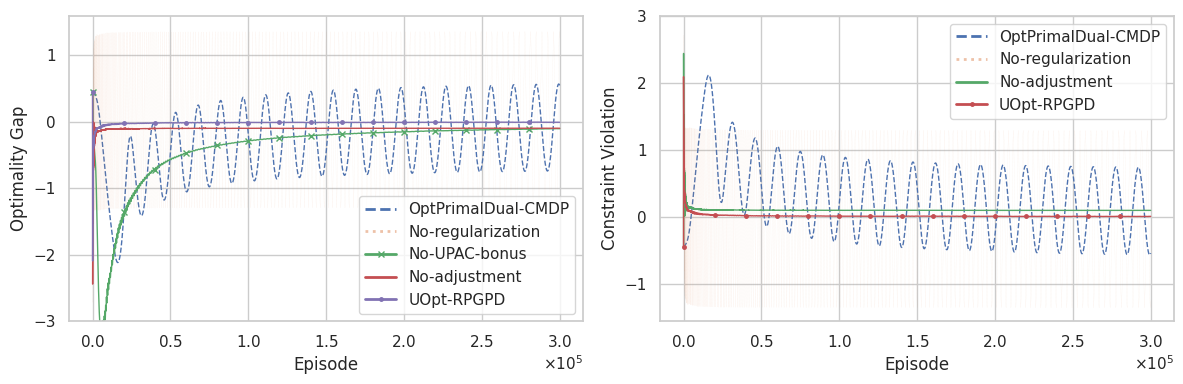

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(12, 4))
sns.set(font_scale=1.0)
axes = []


with sns.axes_style("whitegrid"):
    plt.subplot(1, 2, 1)
    plt.plot(errors_rew, label=f"OptPrimalDual-CMDP", linewidth=1.0, linestyle="--")
    plt.plot(noent_errors_rew, label="No-regularization", linewidth=0.1, alpha=0.5, linestyle=":")
    plt.plot(noupac_errors_rew, label="No-UPAC-bonus", linewidth=1.0, marker="x", markevery=20000, markersize=5)
    plt.plot(noadjust_errors_rew, label="No-adjustment", linewidth=1.0)
    plt.plot(pro_errors_rew, label="UOpt-RPGPD", linewidth=1.0, marker=".", markevery=20000, markersize=5)
    plt.ylabel("Optimality Gap")
    plt.xlabel("Episode")
    plt.ylim(-3.0)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    leg = plt.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

    plt.subplot(1, 2, 2)
    plt.plot(errors_vio, label=f"OptPrimalDual-CMDP", linewidth=1.0, linestyle="--")
    plt.plot(noent_errors_vio, label="No-regularization", linewidth=0.1, alpha=0.5, linestyle=":")
    plt.plot(noadjust_errors_vio, label="No-adjustment", linewidth=1.0)
    plt.plot(pro_errors_vio, label="UOpt-RPGPD", linewidth=1.0, marker=".", markevery=20000, markersize=5)
    plt.ylabel("Constraint Violation")
    plt.xlabel("Episode")
    plt.ylim(None, 3.0)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    leg = plt.legend()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

    plt.tight_layout()

plt.savefig("Experiment.pdf")
plt.savefig("Experiment.png")